# Parameter exploration of a brain network model

This notebook demonstrates how to scan the parameter space of a brain network model using `neurolib`. We will simulate BOLD activity and compare the results to empirical data to identify optimal parameters of the model.

The steps outlined in this notebook are the following:

1. We load a DTI and resting-state fMRI dataset (`hcp`) and set up a brain network using the `FHNModel`.
2. We simulate the system for a range of different parameter configurations.
3. We load the simulated data from disk. 
4. We postprocess the results and obtain the model fit.
5. Finally, we plot the results in the parameter space of the exploration.

In [47]:
#hide
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#hide
import logging
logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

In [3]:
#hide
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib
    import matplotlib.pyplot as plt
    
import numpy as np

# Let's import all the necessary functions for the parameter
from neurolib.models.fhn import FHNModel
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch

# load some utilty functions for explorations
import neurolib.utils.pypetUtils as pu
import neurolib.utils.paths as paths
import neurolib.optimize.exploration.explorationUtils as eu

# The brain network dataset
from neurolib.utils.loadData import Dataset

# Some useful functions are provided here
import neurolib.utils.functions as func

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

## 1. Set up a brain network

We load a dataset (in this case the `hcp` dataset from the Human Connectome Project) and initialize a model to run on each node of the brain network (here the `FHNModel` which is the Fitz-Hugh Nagumo model).

In [ ]:
ds = Dataset("hcp")
model = FHNModel(Cmat = ds.Cmat, Dmat = ds.Dmat)
model.params.duration = 20 * 1000 #ms
# testing: model.params.duration = 20 * 1000 #ms
# original: model.params.duration = 5 * 60 * 1000 #ms

Running the model is as simple as entering `model.run(chunkwise=True)`. 

## 2. Run the exploration

We define a parameter range to explore. Our first parameter is `x_ext`, which is the input to each node of the `FHNModel` in a brain network. Therefore, this parameter is a `list` with `N` entries, one per node. Our next parameter is `K_gl`, the global coupling strength. Finally, we have the `coupling` parameter, which defines how each `FHNModel` is coupled to its adjacent nodes via either `additive` coupling (`activity += input`) or `diffusive` (`activity += (activity - input)` ).

In [ ]:
parameters = ParameterSpace({"x_ext": [np.ones((model.params['N'],)) * a for a in  np.linspace(0, 2, 2)] # testing: 2, original: 41
                             ,"K_gl": np.linspace(0, 2, 2) # testing: 2, original: 41
                             ,"coupling" : ["additive", "diffusive"]
                            }, kind="grid")
search = BoxSearch(model=model, parameterSpace=parameters, filename="example-1.2.0.hdf")

We run the exploration, simply by calling the `run()` function of the `BoxSearch` class. We can pass parameters to this function, that will be directly passed to the `FHNModel.run()` function of the simulated model. This way, we can easily specify to run the simulation `chunkwise`, without storing all the activity in memory, and simulate `bold` activity as well. 

Note that the default behaviour of the `BoxSearch` class is to save the `default_output` of each model and if `bold` is simulated, then also the BOLD data. If the exploration is initialized with `BoxSearch(saveAllModelOutputs=True)`, the exploration would save *all* outputs of the model. This can obviously create a lot of data to store, so please use this option at your own discretion. 

In [ ]:
search.run(chunkwise=True, bold=True)

## 3. Load results

A simple helper function for getting the trajectories of an `hdf` file created by `pypet` can be found in `pypetUtils.py` (aka `pu`). This way, you can explore which explorations are in the file and decide later which one you want to load for analysis

In [23]:
pu.getTrajectorynamesInFile(os.path.join(paths.HDF_DIR, "example-1.2.0.hdf"))

['results-2020-04-08-02H-01M-53S', 'results-2020-04-08-02H-50M-09S']

The default behaviour will load the latest exploration. It's name is also stored in `search.trajectoryName`:

In [21]:
search.trajectoryName

'results-2020-04-08-02H-50M-09S'

Now we load all results. As said above, the newest exploration will be loaded by default. You can load results from earlier explorations by adding the argument `trajectoryName=results-from-earlier` and also chose another `hdf` file by using the argument `filename=/path/to/explorations.hdf`.

Remember that using `search.loadResults()` will load all results to memory. This can cause a lot of RAM, depending on how big the exploration was. 

In [ ]:
search.loadResults()

In [ ]:
print("Number of results: {}".format(len(search.results)))

One way of loading a result without loading everything else into RAM is to use the builtin function `search.getRun()`. However, you need to know which `runId` you're looking for! For this, you can run `search.loadDfResults()` to create a pandas.DataFrame `search.dfResults` with all parameters (which also happens when you call `search.loadResults()`).

In [24]:
search.getRun(6).params

{'x_ext': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'K_gl': 0.15000000000000002,
 'coupling': 'additive'}

After loading the results with `search.loadResults()` they are now available as a simple list using `search.results`. Let's look at the time series of one result.

Text(0, 0.5, 'Activity')

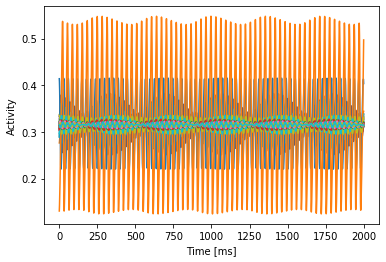

In [56]:
rId = 2 # test:2, original: 1327
plt.plot(search.results[rId].t, search.results[rId].x.T);
plt.xlabel("Time [ms]")
plt.ylabel("Activity")

Using `search.loadResults()` also created a `pandas.DataFrame` with the individual run's parameters and their `runId`.

In [37]:
search.dfResults.iloc[-4:]

,x_ext,K_gl,coupling,fc,max_x,amp_x
3358,2.0,1.95,additive,0.304496,2.446207,1.463651e+00
3359,2.0,1.95,diffusive,0.221238,0.872110,2.275957e-14
3360,2.0,2.00,additive,0.310389,2.489208,1.503437e+00
3361,2.0,2.00,diffusive,0.226729,0.872110,2.253753e-14


If you remember from before, the external input parameter `x_ext` is a `list` of length `N` (one per node). Since they're all the same in this example, we reduce the parameter to only the first entry of each list.

In [30]:
search.dfResults.x_ext = [a[0] for a in list(search.dfResults.x_ext)]

In [31]:
search.dfResults.iloc[-4:]

,x_ext,K_gl,coupling
3358,2.0,1.95,additive
3359,2.0,1.95,diffusive
3360,2.0,2.00,additive
3361,2.0,2.00,diffusive


## 4. Postprocessing

We can use `eu.processExplorationResults()` from `explorationUtils.py` (aka `eu`) to process the results from the simluation and store results in our `pandas.DataFrame` of all results called `search.dfResults`:

In [ ]:
eu.processExplorationResults(search, model=model, ds=ds, bold_transient=10000)

This finally gives us a dataframe with parameters and respective values from postprocessing the results, which we can access using `search.dfResults`.

We can use the utility function `eu.findCloseResults()` to navigate in this DataFrame and find for example the `runId` of a run for a specific parameter configuration.

In [54]:
eu.findCloseResults(search.dfResults, dist=0.2, K_gl=0.5, x_ext = 1.0)

,x_ext,K_gl,coupling,fc,max_x,amp_x
1324,0.80,0.30,additive,0.364910,1.192267,1.428502
1325,0.80,0.30,diffusive,0.302487,0.576765,0.467873
1326,0.80,0.35,additive,0.337226,1.241613,1.511995
1327,0.80,0.35,diffusive,0.187238,0.547917,0.423548
1328,0.80,0.40,additive,0.200489,1.287626,1.590182
...,...,...,...,...,...,...
1909,1.15,0.55,diffusive,0.363809,0.772698,0.577180
1910,1.15,0.60,additive,0.348988,1.234206,1.050313
1911,1.15,0.60,diffusive,0.278103,0.768822,0.566546
1912,1.15,0.65,additive,0.371943,1.276929,1.091328


To understand what is happening in `eu.processExplorationResults()`, it helps to see how we could do postprocessing on the loaded data ourselves. Let's calculate the correlation to empirical functional connectivity using the builtin funtions `func.fc()` and `func.matrix_correlation()`.

In [50]:
mean_corr = np.mean([func.matrix_correlation(func.fc(search.results[rId]['BOLD']), fc) for fc in ds.FCs])

print(f"Mean correlation of run {rId} with empirical FC matrices is {mean_corr:.02}")

Mean correlation of run 3324 with empirical FC matrices is 0.28


## 5. Plot

Another usefull function is `eu.plotExplorationResults()`, which helps you to visualize the results from the exploration. You can specify which parameters should be the x- and the y-axis using the `par1=[parameter_name, parameter_label]` and `par2` arguments, and you can define `by` which paramter plane the results should be "sliced".

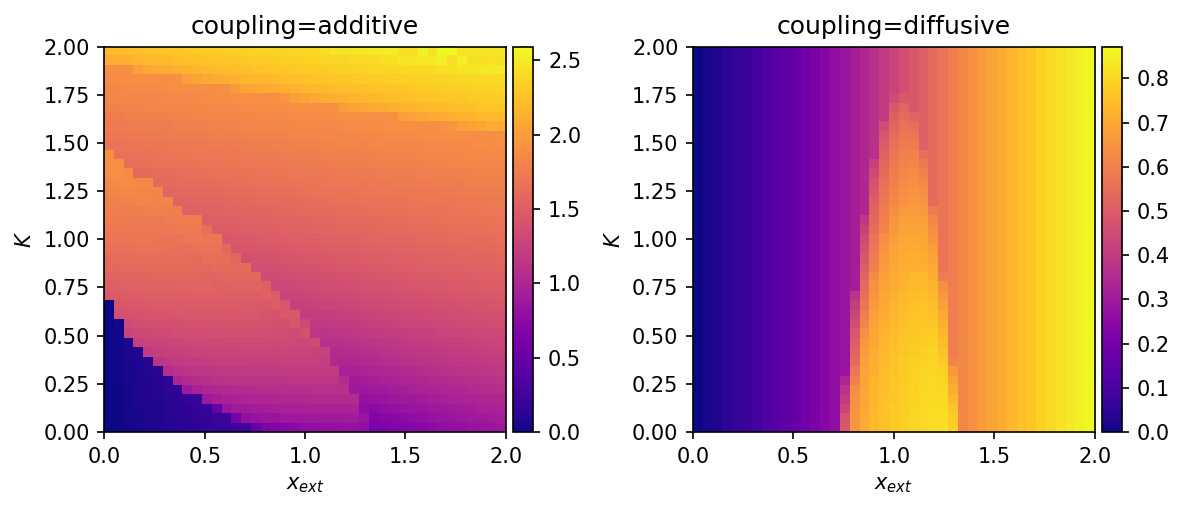

In [52]:
plot_key_label = "Maximum of output"
eu.plotExplorationResults(search.dfResults, par1=['x_ext', '$x_{ext}$'], par2=['K_gl', '$K$'], plot_key='max_x',  by=['coupling'], by_label = ['coupling'], plot_key_label=plot_key_label, one_figure=True)

### BOLD functional connectivity

We want to find parameter for which the brain network model produces realistic BOLD functional connectivity. For this, we calculated the entry `fc` in `search.dfResults` by taking the `func.fc()` of the `model.BOLD` timeseries and compared it to empirical data using `func.matrix_correlation`. 

Below, the average of this value across all subjects of the dataset is plotted. A higher value (brighter color) means a better fit to the empirical data. Observe how the best solutions tend to cluster at the edges of bifurcations, indicating that correlations in the network are generated by multiple nodes undergoing bifurcation together, such as transitioning from the constant activity (fixed point) solution to an oscillation.

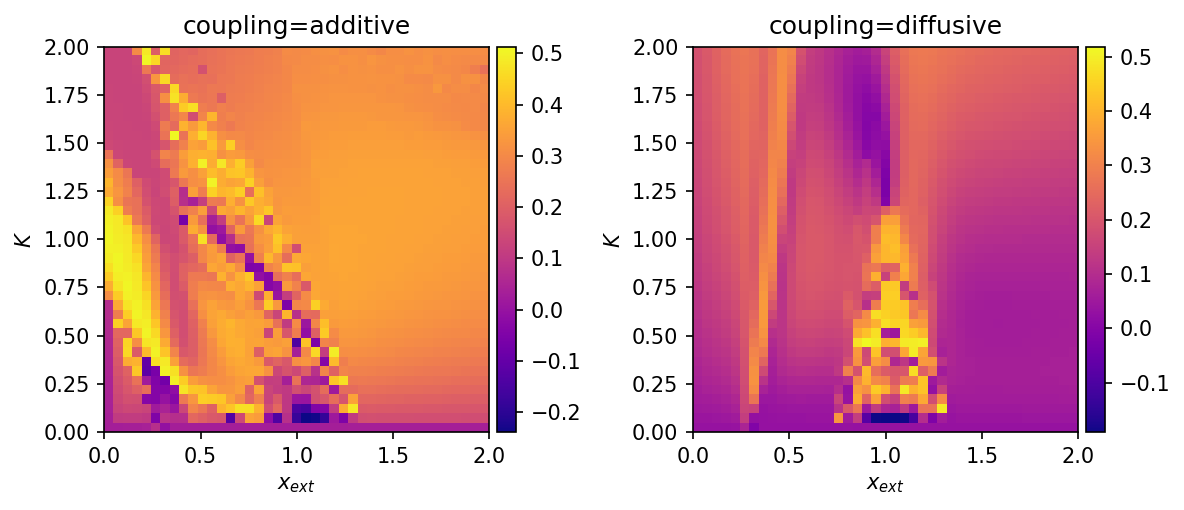

In [58]:
plot_key_label = "FC correlation"
eu.plotExplorationResults(search.dfResults, par1=['x_ext', '$x_{ext}$'], par2=['K_gl', '$K$'], plot_key='fc',  by=['coupling'], by_label = ['coupling'], plot_key_label=plot_key_label, one_figure=True)